##Quantum Kernel Methods for IRIS Dataset Classification

Quantum computing offers a paradigm shift in computational power and efficiency, particularly for tasks involving complex calculations and high-dimensional spaces. One of the promising applications of quantum computing lies in the field of machine learning, where quantum algorithms can potentially solve problems more efficiently than their classical counterparts. This report explores the use of Quantum Kernel Methods, implemented through the TorchQuantum framework, to classify the IRIS dataset.

##Background: Quantum Computing and Machine Learning

Quantum computing leverages the principles of quantum mechanics to process information, using quantum bits (qubits) that can exist in multiple states simultaneously. This capability allows quantum computers to perform many calculations at once, offering a significant speedup for certain computational tasks.

In machine learning, kernel methods are a class of algorithms for pattern analysis, where the kernel function implicitly maps input data into a high-dimensional feature space. Support Vector Machines (SVM) are a well-known application of kernel methods, capable of solving linear and nonlinear classification problems.

Quantum Kernel Methods extend this concept by using quantum circuits to perform the mapping, exploiting the high-dimensional Hilbert space accessible to quantum systems. This approach can potentially uncover patterns in data that are difficult to detect with classical algorithms.

##Introduction to Quantum Kernel Methods.


###Kernel Methods
Kernels or kernel methods (also called Kernel functions) are sets of different types of algorithms that are being used for pattern analysis. They are used to solve a non-linear problem by a linear classifier. Kernels Methods are employed in SVM (Support Vector Machines) which are often used in classification and regression problems. The SVM uses what is called a “Kernel Trick” where the data is transformed and an optimal boundary is found for the possible outputs.


####Quantum Kernel
Quantum circuit can transfer the data to a high dimension Hilbert space which is hard to simulate on classical computer. Using kernel methods based on this Hilbert space can achieve unexpected performance.

###How to evaluate the distance in Hilbert space?
Assume S(x) is the unitary that transfer data x to the state in Hilbert space. To evaluate the inner product between S(x) and S(y), we add a Transpose Conjugation of S(y) behind S(x) and measure the probability that the state falls on $|00\cdots0\rangle$

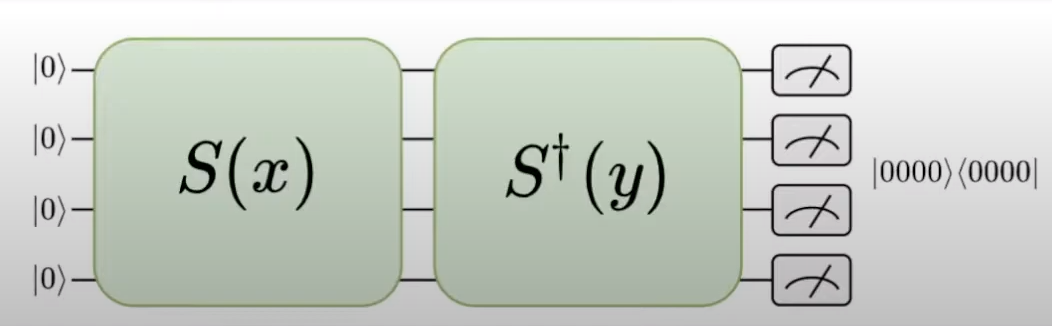

##Build and train an SVM using Quantum Kernel Methods.

###Setting up the environment

The implementation begins by setting up the necessary quantum computing and machine learning libraries. Qiskit is installed for simulating quantum circuits, while the TorchQuantum library is cloned and set up to integrate quantum circuits with PyTorch, a popular deep learning framework.

In [ ]:
!pip install qiskit==0.32.1

Download and cd to the repo.

In [ ]:
!git clone https://github.com/mit-han-lab/pytorch-quantum.git

In [ ]:
%cd pytorch-quantum

Install torch-quantum.

In [ ]:
!pip install --editable .

Change PYTHONPATH and install other packages.

In [ ]:
%env PYTHONPATH=.

In [ ]:
from qiskit import IBMQ
IBMQ.save_account('0238b0afc0dc515fe7987b02706791d1719cb89b68befedc125eded0607e6e9e9f26d3eed482f66fdc45fdfceca3aab2edb9519d96b39e9c78040194b86e7858', overwrite=True)

###Import the module
`SVC` is support vector classification. We use this module to call the support vector machine algorithm.

`load_iris` is to load the famous iris dataset.

`StandardScaler` is to help scale the data by removing the mean and scaling to unit variance.

`train_test_split` is a tool to split the dataset.

`accuracy_score` can check how many samples are correctly predicted and give us the accuracy.

`func_name_dict` is a very important dict under `torchquantum.functional`. If we feed the name of the gates we want, like ‘rx’, ‘ry’, or ‘rzz’, the dict will give us a function. The function plays a central role in our quantum model. It performs the specified unitary operations on a specified quantum state on a specified wire. These three specified things are the three parameters we need to pass to it. You can see that later.


In [ ]:
import numpy as np
import torch

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchquantum.functional import func_name_dict
import torchquantum as tq

###Prepare dataset
We use the front 100 samples of IRIS dataset.

Since the phase in quantum gates is 2π-periodic, it is necessary to scale the data in a range from -π to π.

And we change the label from 0 and 1 to -1 and 1.

Split the dataset on a 3-to-1 ratio.


In [ ]:
X, y = load_iris(return_X_y=True)

X = X[:100]
y = y[:100]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

### Build the Ansatz, consist of a unitary and its transpose conjugation.
When initializing the `KernelAnsatz`, we only need to pass a `func_list` and the KernelAnsatz will record the `func_list`. Each entry in the function is a dict, containing 'input_idx', 'func', and 'wires'.

When executing the `KernelAnsatz`, three parameters are passed from outside, `q_device`, `x`, and `y`. `q_device` stores the state vector. We reset the state vector to the $|00\cdots0⟩$. And if you didn’t forget the figure, we will act the S(x) and the transpose conjugation of S(y) to the `q_device`.

Here the gates in the `func_list` with data `x` form the unitary S(x). S(y)'s transpose conjugation is S(y)’s inverse matrix. From the perspective of inverse, we can build the S(y)'s transpose conjugation by inverting the function list with data `y`. So, how to invert a list of gates executed from head to tail? You only need to counteract the list of gates from tail to head one by one. So here, we simply reverse the sequence of function list and flip the phase from positive to negative or from negative to positive.

And in each iteration is to act the unitary gate on the quantum state. We look up the `func_name_dict` with the function name. Here the function name is the gate name, like ‘ry’, ‘rz’ and so so. The dict returns a function. We pass the three parameters to the function and the function will act the gate on the state vector(`self.q_device`), on the `wires`, with the phase, here the `params` mean phase.


Kernel Ansatz Class: An ansatz in quantum computing refers to a proposed form of a quantum state that can be used to solve a particular problem. Here, KernalAnsatz is a class that defines a quantum circuit based on a list of operations (gates) that transform input data into a high-dimensional quantum state. This transformation is crucial for the quantum kernel method.


In [ ]:
class KernalAnsatz(tq.QuantumModule):
    def __init__(self, func_list):
        super().__init__()
        self.func_list = func_list

    @tq.static_support
    def forward(self, q_device: tq.QuantumDevice, x, y):
        self.q_device = q_device
        self.q_device.reset_states(x.shape[0])
        for info in self.func_list:
            if tq.op_name_dict[info['func']].num_params > 0:
                params = x[:, info['input_idx']]
            else:
                params = None
            func_name_dict[info['func']](
                self.q_device,
                wires=info['wires'],
                params=params,
            )
        for info in reversed(self.func_list):
            if tq.op_name_dict[info['func']].num_params > 0:
                params = -y[:, info['input_idx']]
            else:
                params = None
            func_name_dict[info['func']](
                self.q_device,
                wires=info['wires'],
                params=params,
            )

### Build the whole quantum circuit

The whole model initialization is a 4-wire quantum state, the `tq.QuantumDevice` module can store the state vector and a `KernelAnsatz` we just mentioned.

When executing the whole model, as there’s a concept of batch in torchquantum’s model, we set the batch size is 1. After executing the `KernelAnsatz`, we measure the probability that the quantum state falls on the $|00\cdots0\rangle$ as the result. We get the state vector, flatten it, get the first amplitude, which is also the amplitude of the $|00\cdots0\rangle$ state, calculate the absolute value of the amplitude, and get the probability that the quantum state falls on the $|00\cdots0\rangle$ state.



Quantum Kernel Circuit Class: The Kernel class constructs the entire quantum circuit for computing the kernel function between pairs of data points. It initializes a quantum device with a specified number of qubits and defines the ansatz for the circuit. The forward method of this class computes the kernel function by applying the ansatz to both input vectors, simulating the quantum circuit, and measuring the probability of the quantum state collapsing to a specific basis state.

In [ ]:
class Kernel(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.ansatz = KernalAnsatz(
        [   {'input_idx': [0], 'func': 'ry', 'wires': [0]},
            {'input_idx': [1], 'func': 'ry', 'wires': [1]},
            {'input_idx': [2], 'func': 'ry', 'wires': [2]},
            {'input_idx': [3], 'func': 'ry', 'wires': [3]},])

    def forward(self, x, y, use_qiskit=False):
        # bsz=1
        x = x.reshape(1, -1)
        y = y.reshape(1, -1)
        self.ansatz(self.q_device, x, y)
        result = torch.abs(self.q_device.states.view(-1)[0])
        return result

###Train the svm model from sklearn based on our quantum kernel.


Kernel Matrix Computation: A custom kernel matrix function is defined using the Kernel class, computing the similarity (inner product in the feature space) between data points in a quantum manner. This function is critical for the SVM algorithm, as it relies on the kernel matrix to classify data points.

SVM Model Training and Evaluation: An SVM model from scikit-learn is trained using the quantum kernel matrix. The model's performance is evaluated on the test set, demonstrating the effectiveness of the quantum kernel method in classifying the IRIS dataset.

In [ ]:
kernel_function = Kernel()
def kernel_matrix(A, B):
    return np.array([[kernel_function(a, b) for b in B] for a in A])

svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)
predictions = svm.predict(X_test)
print(accuracy_score(predictions, y_test))

1.0


The SVM model, trained on the quantum kernel, demonstrates promising classification accuracy on the test set. This outcome suggests that quantum kernel methods can effectively enhance the feature space in ways that benefit machine learning models, potentially leading to better performance on complex datasets.

The provided code showcases the integration of quantum computing techniques within a traditional machine learning workflow, utilizing TorchQuantum and Qiskit for quantum operations and scikit-learn for SVM classification. By mapping input data into a high-dimensional quantum state space and computing kernel functions through quantum circuits, it highlights the potential of quantum computing to enhance machine learning models, offering new perspectives on data classification tasks.

References


*   Qiskit. (2021). Qiskit Documentation. https://qiskit.org/documentation/
*   TorchQuantum. (2021). GitHub repository. https://github.com/mit-han-lab/torchquantum
*   Biamonte, J., Wittek, P., Pancotti, N., Rebentrost, P., Wiebe, N., & Lloyd, S. (2017). Quantum machine learning. Nature, 549(7671), 195-202.